## init

In [2]:
# !pip install torch
# !pip install nilearn
# !pip install matplotlib
# !pip install numpy
# !pip install torchsummary

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torchvision import transforms
import os

In [4]:
!nvidia-smi

Thu Apr 14 21:21:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:0B:00.0 Off |                    0 |
|  0%   90C    P0    82W / 150W |   6384MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A10          Off  | 00000000:84:00.0 Off |                    0 |
|  0%   

In [5]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 0

Torch version: 1.11.0+cu113
Using GPU


## loading data

In [6]:
!ls data

# from google.colab import drive
# drive.mount('/content/drive')

labels.npy  tensors.npy


In [7]:
# labels = np.load("/content/drive/MyDrive/anat/labels.npy")
# tensors = np.load("/content/drive/MyDrive/anat/tensors.npy")

labels = np.load("data/labels.npy")
tensors = np.load("data/tensors.npy")

In [8]:
labels.shape, tensors.shape

((1113,), (1113, 58, 70, 58))

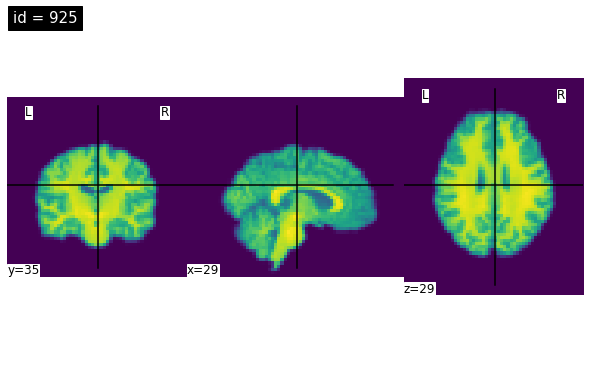

In [9]:
i = random.randint(0, len(tensors) - 1)
t = tensors[i]
tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=f'id = {i}');

## preprocessing

In [10]:
def cut_edges(brain):
    return brain[5:-5, 7:-5, 4:-11]

tensors = tensors[:, 5:-5, 7:-5, 4:-11]
tensors.shape

(1113, 48, 58, 43)

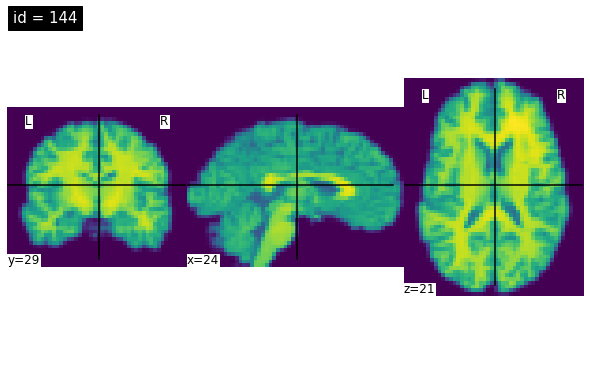

In [11]:
i = random.randint(0, len(tensors) - 1)
t = tensors[i]
tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=f'id = {i}');

In [12]:
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))

## models

In [13]:
def display_brain(tensors, i=None, label=None):
    i = random.randint(0, len(tensors) - 1) if i is None else i
    label = f'id = {i}' if label is None else label
    t = tensors[i]
    tim = nib.Nifti1Image(t, np.diag([1,1,1,1]))
    plotting.plot_img(tim, [s / 2 for s in tim.shape], figure=plt.figure(figsize=(8, 5)), title=label);

In [14]:
class AE3dConstChan(nn.Module):
    def __init__(self, blocks=3, channels=16, extr_ch=16):
        super().__init__()
        self.encoder_blocks = []
        self.pools = [nn.MaxPool3d(2, 2, return_indices=True)] * blocks
        for b in range(blocks):
            self.encoder_blocks += [nn.Sequential(
                    nn.Conv3d(1 if b==0 else channels, channels, 3, 1, 1), 
                    nn.ReLU(),
                    nn.BatchNorm3d(channels),

                    nn.Conv3d(channels, channels, 3, 1, 1), 
                    nn.ReLU(),
                    nn.BatchNorm3d(channels),
            )]
        

        self.feat = nn.Sequential(
                    nn.Conv3d(channels, channels, 3, 1, 1), 
                    nn.ReLU(),
                    nn.Conv3d(channels, extr_ch, 3, 1, 1),
                    nn.Flatten()
        )
        self.unflat = nn.Unflatten(1, [extr_ch, 6, 7, 5])     # как автоматически ?

        
        self.decoder_blocks = []        
        self.unpools = [nn.MaxUnpool3d(2, 2)] * blocks
        for b in range(blocks):
            self.decoder_blocks += [nn.Sequential(
                    nn.ConvTranspose3d(extr_ch if b==0 else channels, channels, 3, 1, 1), 
                    nn.ReLU(),
                    nn.BatchNorm3d(channels),

                    nn.ConvTranspose3d(channels, channels, 3, 1, 1), 
                    nn.ReLU(),
                    nn.BatchNorm3d(channels),
            )]

        self.reconstruct = nn.Sequential(
                    nn.ConvTranspose3d(channels, channels, 3, 1, 1),
                    nn.ReLU(),
                    nn.ConvTranspose3d(channels, 1, 3, 1, 1),
        )

    
    def encode(self, x):
        self.indicies = []
        self.output_sizes = []

        for i in range(len(self.encoder_blocks)):
            self.output_sizes.append(x.shape)
            x = self.encoder_blocks[i](x)
            x, ind = self.pools[i](x)
            self.indicies.append(ind)

        x = self.feat(x)
        return x
    

    def decode(self, x):
        x = self.unflat(x)

        for i in range(len(self.decoder_blocks)):
            x = self.decoder_blocks[i](x)
            x = self.unpools[i](x, self.indicies[-i-1], self.output_sizes[-i-1])

        x = self.reconstruct(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    
    def cuda(self):
        for i in range(len(self.encoder_blocks)):
            self.encoder_blocks[i].cuda()
            self.pools[i].cuda()
            self.decoder_blocks[i].cuda()
            self.unpools[i].cuda()
        self.feat.cuda()
        self.unflat.cuda()
        self.reconstruct.cuda()
        return self

In [15]:
class AE3b16_32ch32f(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16),
                nn.Conv3d(16, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16))

        self.block2 = nn.Sequential(
                nn.Conv3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(32, 32, 3, 1, 1),
                nn.Flatten())
        
        # decoder:
        
        self.unflat = nn.Unflatten(1, [32, 6, 7, 5])
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16),
                nn.ConvTranspose3d(16, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(16, 16, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(16, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        return x
    
    def decode(self, x):
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [16]:
class AE3b32ch16f(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))

        self.block2 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(16, 16, 3, 1, 1),
                nn.Flatten())
        
        # decoder:
        
        self.unflat = nn.Unflatten(1, [16, 6, 7, 5])
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(32, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        return x
    
    def decode(self, x):
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [36]:
model = AE3b32ch16f().cuda()
summary(model, ds[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 48, 58, 43]             896
              ReLU-2       [-1, 32, 48, 58, 43]               0
       BatchNorm3d-3       [-1, 32, 48, 58, 43]              64
            Conv3d-4       [-1, 32, 48, 58, 43]          27,680
              ReLU-5       [-1, 32, 48, 58, 43]               0
       BatchNorm3d-6       [-1, 32, 48, 58, 43]              64
         MaxPool3d-7  [[-1, 32, 24, 29, 21], [-1, 32, 24, 29, 21]]               0
            Conv3d-8       [-1, 32, 24, 29, 21]          27,680
              ReLU-9       [-1, 32, 24, 29, 21]               0
      BatchNorm3d-10       [-1, 32, 24, 29, 21]              64
           Conv3d-11       [-1, 32, 24, 29, 21]          27,680
             ReLU-12       [-1, 32, 24, 29, 21]               0
      BatchNorm3d-13       [-1, 32, 24, 29, 21]              64
        MaxPool3d-14

/home/kondrateva/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:847: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool3d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [37]:
np.cumprod(tensors[0].shape)[-1] / 3360

35.628571428571426

In [18]:
def create_stop_crit(buff):
    
    def stop_crit(loss):
        if len(loss) < buff:
            return False
        return np.mean(loss[-buff:]) < loss[-1]
    
    return stop_crit

In [19]:
def train(model, loader, valloader, optimizer, criterion, epochs=500, start_e=0, save_n=25,
          stop=(lambda loss:  False), exp_name='undef_exp', folder='unsorted'):

    recloss = []
    vals = []
    if folder not in os.listdir():
        os.mkdir(folder)
    for e in range(start_e, epochs):
        running_loss = 0
        model.train()
        for i, (X, y) in tqdm(enumerate(loader)):
            X = X.cuda()

            outs = model(X)
            loss = criterion(outs, X)
            running_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        recloss.append(running_loss.item() / len(loader))
        
        model.eval()
        valloss = 0
        with torch.no_grad():
            for X, y in valloader:
                X = X.cuda()
                outs = model(X)
                valloss += criterion(outs, X)

        vals.append(valloss.item() / len(valloader))
        
        # visualize
        clear_output(True)
        print('Epoch', e)
        print('Reconstruction Loss: ', recloss[-1])
        print('Validation Loss: ', vals[-1])
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(range(start_e, e + 1), recloss)
        ax[1].plot(range(start_e, e + 1), vals)
        ax[0].set_title('Reconstruction loss')
        ax[1].set_title('Validation Loss')

        t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        t2 = nib.Nifti1Image(outs[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        f = plt.figure(figsize=(10, 6))
        ax = plt.subplot(2, 1, 1)
        plotting.plot_img(t1, [s / 2 for s in t1.shape], title="Truth", axes=ax)
        ax = plt.subplot(2, 1, 2)
        plotting.plot_img(t2, [s / 2 for s in t2.shape], title="Reconstructed", axes=ax)
        plt.show()

        if e % save_n == 0:
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_"}{start_e + e}')

        if stop(vals):
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_crit_"}{start_e + e}')
            return

## experiments

### exp 1

Epoch 40
Reconstruction Loss:  3543.908761160714
Validation Loss:  3417.9308035714284


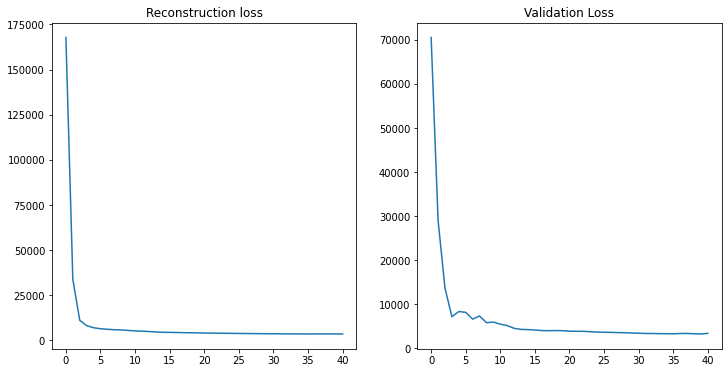

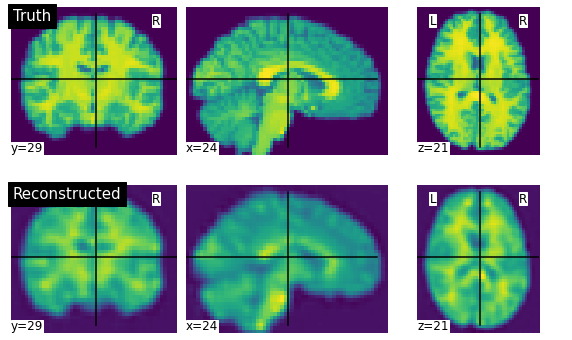

In [28]:
model = AE3b16_32ch32f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='full_16-32x32', folder='ae_exp1_norm_crit')

In [41]:
model = AE3b16_32ch32f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
criterion = lambda x, y: nn.MSELoss(x, y) + nn.BCELoss(x, y)
stop_crit = create_stop_crit(buff=10)

train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='full_16-32x32', folder='ae_exp1_norm_crit')

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### exp 2 
(extended buffer of stop criterion, added weight_decay)

Epoch 46
Reconstruction Loss:  3243.500558035714
Validation Loss:  3602.265625


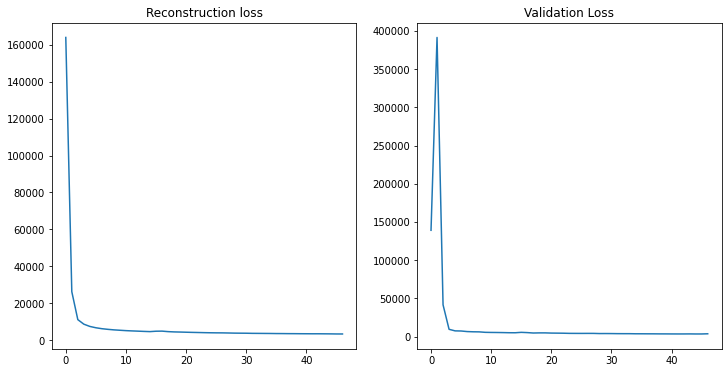

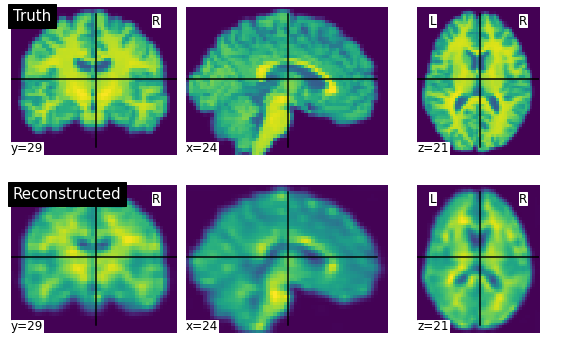

In [32]:
model = AE3b32ch32f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999), weight_decay=1e-4)
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=15)

train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='full_16-32x32', folder='ae_exp1_norm_crit')

### exp3 
all blocks have 32 channels except feature extraction, so embeding size is twice less

Epoch 40
Reconstruction Loss:  2549.917410714286
Validation Loss:  2608.3507254464284


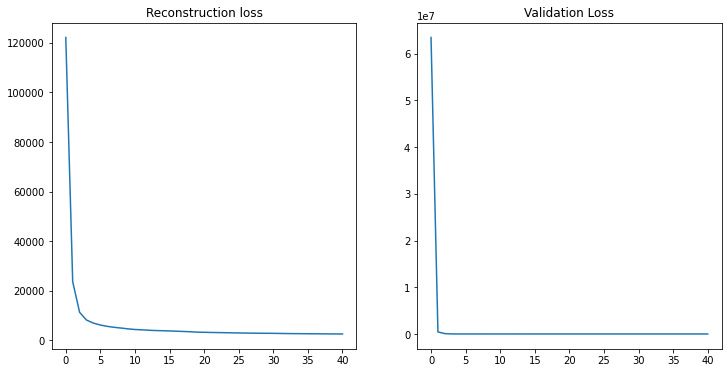

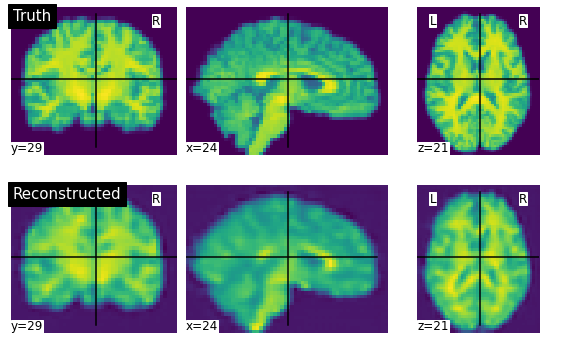

In [54]:
model = AE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='full_32x16', folder='ae_exp2')

### exp 3.5 
- normalized data + lr=0.001

Epoch 41
Reconstruction Loss:  0.0157444743173463
Validation Loss:  0.017068862915039062


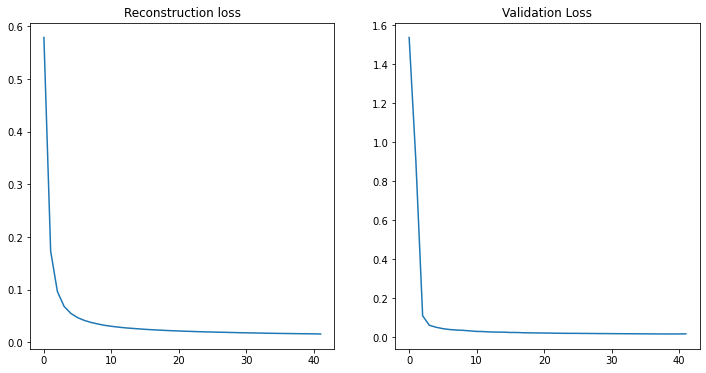

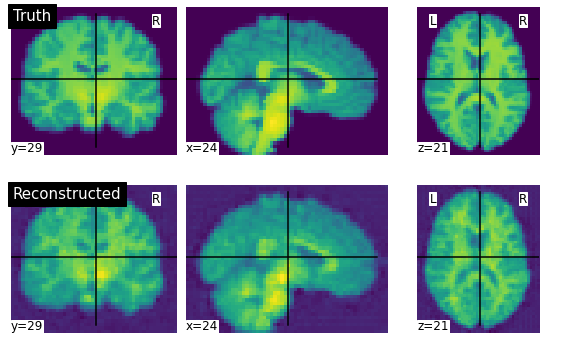

In [23]:
model = AE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=64)
optimizer = optim.Adam(model.parameters(),  lr = 0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()
stop_crit = create_stop_crit(buff=10)

train(model, trainloader, valloader, optimizer, criterion, stop=stop_crit, start_e=0,
      exp_name='AE3b32ch32f', folder='ae_exp3.5norm')

In [ ]:
    self.encoder = nn.Sequential(
        nn.Conv3d(1, 64, kernel_size=3, padding=1), 
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, hidden_dim, kernel_size=3, padding=1), 
        nn.AdaptiveAvgPool3d((1, 1, 1)),
        nn.Flatten()
    )

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (hidden_dim, 1, 1, 1)), 
        nn.Upsample(size=(3, 4, 3), mode='trilinear',), 
        nn.Conv3d(hidden_dim, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(7, 8, 7), mode='trilinear'), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(14, 17, 14), mode='trilinear'), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(29, 35, 29), mode='trilinear'), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(58, 70, 58), mode='trilinear'), 
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, 1, kernel_size=3, padding=1)
    )